In [9]:
# Load packages
using Turing, Gadfly

In [10]:
# Define helper functions

# Sigmod function
function sigmoid(t)
  return 1 / (1 + e^(-t))
end

# The Neural Net
function nn(x, b1, w11, w12, w13, w14, b2, w21, w22, bo, wo)
  # wi = weight_in, wh = weight_hidden, wo = weight_out
  h1 = tanh([w11' * x + b1[1]; w12' * x + b1[2]; w13' * x + b1[3]; w14' * x + b1[4]])
  h2 = tanh([w21' * h1 + b2[1]; w22' * h1 + b2[2]])
  return sigmoid((wo' * h2)[1] + bo)
end

# Bayesian prediction - averaging predcitions from all samples
function predict(x, chain)
  n = length(chain[:b1])
  b1 = chain[:b1]
  w11 = chain[:w11]
  w12 = chain[:w12]
  w13 = chain[:w13]
  w14 = chain[:w14]
  b2 = chain[:b2]
  w21 = chain[:w21]
  w22 = chain[:w22]
  bo = chain[:bo]
  wo = chain[:wo]
  return mean([nn(x, b1[i], w11[i], w12[i], w13[i], w14[i], b2[i], w21[i], w22[i], bo[i], wo[i]) for i in 1:n])
end

predict (generic function with 1 method)

The Neural Network defined here is shwon in the figure below.
<img src="fig/bnn.png">

In [11]:
# Generating 200 training data
N = 200
M = round(Int64, N / 4)
x1s = rand(M) * 5
x2s = rand(M) * 5
xt1s = Array([[x1s[i]; x2s[i]] for i = 1:M])
append!(xt1s, Array([[x1s[i] - 6; x2s[i] - 6] for i = 1:M]))
xt0s = Array([[x1s[i]; x2s[i] - 6] for i = 1:M])
append!(xt0s, Array([[x1s[i] - 6; x2s[i]] for i = 1:M]))

xs = [xt1s; xt0s];
ts = [ones(M); ones(M); zeros(M); zeros(M)];

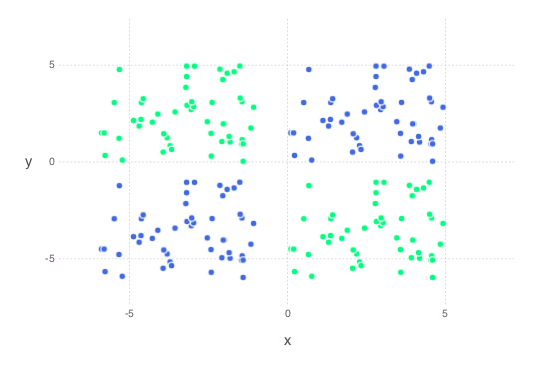

In [14]:
# Plot data points
d1_layer = layer(x=map(e -> e[1], xt1s), y=map(e -> e[2], xt1s), Geom.point, Theme(default_color=colorant"royalblue"))
d2_layer = layer(x=map(e -> e[1], xt0s), y=map(e -> e[2], xt0s), Geom.point, Theme(default_color=colorant"springgreen"))

plot(d1_layer, d2_layer, Coord.Cartesian(xmin=-7, xmax=7, ymin=-7, ymax=7))

In [21]:
# Define the model
alpha = 0.16            # regularizatin term
var = sqrt(1.0 / alpha) # variance of the Gaussian prior
@model bnn begin
  @assume w11 ~ MvNormal([0; 0], [var 0; 0 var])
  @assume w12 ~ MvNormal([0; 0], [var 0; 0 var])
  @assume w13 ~ MvNormal([0; 0], [var 0; 0 var])
  @assume w14 ~ MvNormal([0; 0], [var 0; 0 var])
  @assume b1 ~ MvNormal([0 ;0; 0; 0], [var 0 0 0; 0 var 0 0; 0 0 var 0; 0 0 0 var])

  @assume w21 ~ MvNormal([0 ;0; 0; 0], [var 0 0 0; 0 var 0 0; 0 0 var 0; 0 0 0 var])
  @assume w22 ~ MvNormal([0 ;0; 0; 0], [var 0 0 0; 0 var 0 0; 0 0 var 0; 0 0 0 var])
  @assume b2 ~ MvNormal([0 ;0], [var 0; 0 var])

  @assume wo ~ MvNormal([0; 0], [var 0; 0 var])
  @assume bo ~ Normal(0, var)

  for i = rand(1:N, 25)
    y = nn(xs[i], b1, w11, w12, w13, w14, b2, w21, w22, bo, wo)
    @observe ts[i] ~ Bernoulli(y)
  end
  @predict b1 w11 w12 w13 w14 b2 w21 w22 bo wo
end

bnn (generic function with 1 method)

In [22]:
# Train 
# NOTE: this model has 25 dimensions and would take ~25s to get 1000 samples
@time chain = sample(bnn, HMC(1000, 0.1, 5));

[HMC]: Finshed with accept rate = 0.449 (re-runs for 0 times)
 23.198220 seconds (100.79 M allocations: 6.093 GB, 6.56% gc time)


 in depwarn at deprecated.jl:73
 in apply_statistic at /Users/kai/.julia/v0.4/Gadfly/src/statistics.jl:1531
 in apply_statistics at /Users/kai/.julia/v0.4/Gadfly/src/statistics.jl:38
 in render_prepare at /Users/kai/.julia/v0.4/Gadfly/src/Gadfly.jl:671
 in render at /Users/kai/.julia/v0.4/Gadfly/src/Gadfly.jl:718
 in writemime at /Users/kai/.julia/v0.4/Gadfly/src/Gadfly.jl:855
 in sprint at iostream.jl:206
 in display_dict at /Users/kai/.julia/v0.4/IJulia/src/execute_request.jl:28
 in execute_request at /Users/kai/.julia/v0.4/IJulia/src/execute_request.jl:195
 in eventloop at /Users/kai/.julia/v0.4/IJulia/src/IJulia.jl:138
 in anonymous at task.jl:447
while loading /Users/kai/.julia/v0.4/IJulia/src/kernel.jl, in expression starting on line 35
 in depwarn at deprecated.jl:73
 in apply_statistic at /Users/kai/.julia/v0.4/Gadfly/src/statistics.jl:1531
 in apply_statistics at /Users/kai/.julia/v0.4/Gadfly/src/statistics.jl:38
 in render_prepare at /Users/kai/.julia/v0.4/Gadfly/src/Gadfly.j

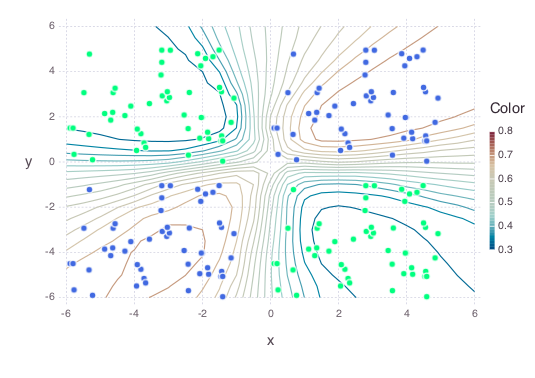


 in depwarn at deprecated.jl:73
 in apply_statistic at /Users/kai/.julia/v0.4/Gadfly/src/statistics.jl:1531
 in apply_statistics at /Users/kai/.julia/v0.4/Gadfly/src/statistics.jl:38
 in render_prepare at /Users/kai/.julia/v0.4/Gadfly/src/Gadfly.jl:671
 in render at /Users/kai/.julia/v0.4/Gadfly/src/Gadfly.jl:718
 in writemime at /Users/kai/.julia/v0.4/Gadfly/src/Gadfly.jl:846
 in sprint at iostream.jl:206
 in display_dict at /Users/kai/.julia/v0.4/IJulia/src/execute_request.jl:38
 in execute_request at /Users/kai/.julia/v0.4/IJulia/src/execute_request.jl:195
 in eventloop at /Users/kai/.julia/v0.4/IJulia/src/IJulia.jl:138
 in anonymous at task.jl:447
while loading /Users/kai/.julia/v0.4/IJulia/src/kernel.jl, in expression starting on line 35


In [23]:
# Plot predictions
p_layer = layer(z=(x,y) -> predict([x, y], chain), x=linspace(-6,6,25), y=linspace(-6,6,25), Geom.contour)

plot(d1_layer, d2_layer,p_layer)